In [1]:
import os

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import random

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
AGE_CLASS = {'(0,2)':0,'(4,6)':1 
             ,'(8,13)':2,'(15,20)':3
             ,'(25,32)':4,'(38,43)':5
             ,'(48,53)':6,'(60,100)':7}

GENDER_CLASS = {'m':0,'f':1}

In [3]:
PATH = 'data/'

path_image = []
path_landmarks = []
age_labels = []
gender_labels = []

with open(PATH+'fold_frontal_0_data.txt') as f:
    lines = f.readlines()

In [4]:
def get_filepath_andlabel(s_from_datatxt):
    #we only get files from faces folder

    properties = s_from_datatxt.split()
    path_image = 'faces/'+properties[0]+'/'+'coarse_tilt_aligned_face.'+properties[2]+'.'+properties[1]
    path_landmarks = 'faces/'+properties[0]+'/'+'landmarks.'+properties[2]+'.'+properties[1]
    encode_class = ''.join([properties[3],properties[4]])
    if encode_class not in AGE_CLASS: return None,None,None,None
    age_label = AGE_CLASS[encode_class]
    
    if properties[5] not in GENDER_CLASS: return None,None,None,None
    gender_label = GENDER_CLASS[properties[5]]

    return path_image,path_landmarks,age_label,gender_label

In [5]:
for i in range(len(lines[2:])):
    path1,path2,age_label,gender_label = get_filepath_andlabel(lines[i])
    if not path1: continue
    path_image.append(path1); age_labels.append(age_label); gender_labels.append(gender_label)
    path_landmarks.append(path2)

In [6]:
path_image = np.array(path_image)
path_landmarks = np.array(path_landmarks)
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

In [7]:
def get_cropped(path_image, path_landmark):
    img = cv2.imread(PATH+path_image)
    with open(PATH+'faces/30601258@N03/landmarks.8.8747478879_afab76198a_o.txt') as g:
        L = g.readlines()
    getXY = [L[2:][i].split(',')[4:] for i in range(len(L[2:]))]
    getXY = np.array(getXY).astype(float)
    Xmin,Ymin = min(getXY[:,0]),min(getXY[:,1])
    Xmax,Ymax = max(getXY[:,0]),max(getXY[:,1])
    return img[int(Ymin):int(Ymax),int(Xmin):int(Xmax)]

In [8]:
labs = [0,0,0,0,0,0,0,0]
# getting the cropped images and labels
age_labels = list(age_labels)
gender_labels = list(gender_labels)

X = [get_cropped(path1,path2) for path1,path2 in tqdm(zip(path_image,path_landmarks))]
Xall = []
age_all = []
gen_all = []
for i,img in enumerate(X,start=0):
    try: 
        if labs[age_labels[i]] < 100: 
            img = cv2.resize(img,(227,227),interpolation=cv2.INTER_AREA)
            Xall.append(img)
            #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #Xall.append(gray.reshape(gray.shape[0],gray.shape[1],1))
            age_all.append(age_labels[i]); gen_all.append(gender_labels[i])
            labs[age_labels[i]] = labs[age_labels[i]] + 1
    except: 
        print('continue')

Xall = np.array(Xall)
age_all = np.array(age_all)
gen_all = np.array(gen_all)

2679it [00:08, 317.79it/s]


continue
continue
continue
continue
continue
continue
continue
continue


In [9]:
# # Xcorrect = []
# age_L = []
# gender_L = []
# for i in range(len(Xall)):
#     plt.imshow(Xall[i])
#     plt.show()
#     bl = input('ok?')
#     if int(bl): 
#         Xcorrect.append(Xall[i])
#         age_L.append(age_all[i])
#         gender_L.append(gen_all[i])

In [10]:
# here we first deal with age
ratio = 0.8
indexes = random.sample(list(range(Xall.shape[0])),int(ratio*Xall.shape[0]))
excluded = np.delete(np.array(range(Xall.shape[0])), indexes)
X_train,y_tr = Xall[indexes],age_all[indexes]
X_test,y_te = Xall[excluded],age_all[excluded]

In [11]:
X_train.shape, X_test.shape

((553, 227, 227, 3), (139, 227, 227, 3))

In [12]:
y_tr.shape, y_te.shape

((553,), (139,))

In [13]:
num_classes = len(AGE_CLASS) #here we do age first

In [14]:
y_train, y_test = [], []

for i in range(len(y_tr)):
    tmp = np.zeros(num_classes)
    tmp[y_tr[i]] = 1
    y_train.append(tmp)
    
for i in range(len(y_te)):
    tmp = np.zeros(num_classes)
    tmp[y_te[i]] = 1
    y_test.append(tmp)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
input_shape = (227,227,3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 55, 55, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 53, 53, 128)       73856     
__________

In [20]:
model_check = ModelCheckpoint('age.h5', monitor='val_loss')
batch_size = 64
epochs = 25
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test)
         ,shuffle=True,callbacks=[model_check])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 553 samples, validate on 139 samples
Epoch 1/25
553/553 [==============================] - 5s 8ms/step - loss: 2.8788 - acc: 0.1826 - val_loss: 2.3545 - val_acc: 0.1799
Epoch 2/25
553/553 [==============================] - 2s 4ms/step - loss: 1.8514 - acc: 0.3020 - val_loss: 2.2522 - val_acc: 0.2158
Epoch 3/25
553/553 [==============================] - 2s 4ms/step - loss: 1.6654 - acc: 0.3942 - val_loss: 2.4205 - val_acc: 0.2230
Epoch 4/25
553/553 [==============================] - 2s 4ms/step - loss: 1.5545 - acc: 0.4340 - val_loss: 2.1408 - val_acc: 0.2590
Epoch 5/25
553/553 [==============================] - 2s 4ms/step - loss: 1.4269 - acc: 0.5063 - val_loss: 1.7109 - val_acc: 0.3885
Epoch 6/25
553/553 [==============================] - 2s 4ms/step - loss: 1.2867 - acc: 0.5371 - val_loss: 1.9869 - val_acc: 0.3094
Epoch 7/25
553/553 [==============================] - 2s 4ms/step - loss: 1.0453 - acc: 0.6365 - val_loss: 1.9582 - val_acc: 0.3669
Epoch 8/25
553/553 [==========

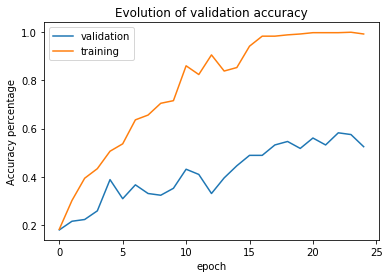

In [44]:
plt.plot(list(range(25)),hist.history['val_acc'],label='validation')
plt.plot(list(range(25)),hist.history['acc'],label='training')
plt.title('Evolution of validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy percentage')
plt.show()

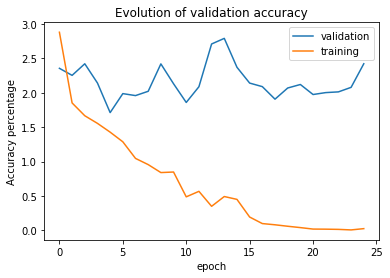

In [45]:
plt.plot(list(range(25)),hist.history['val_loss'],label='validation')
plt.plot(list(range(25)),hist.history['loss'],label='training')
plt.title('Evolution of validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy percentage')
plt.show()

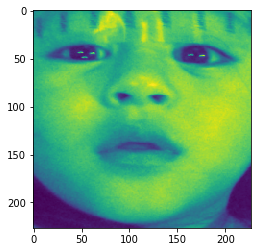

In [64]:
plt.imshow(Xall[150].reshape(Xall[1].shape[0],Xall[1].shape[1]))

In [110]:
img = Xall[150]
model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))

array([[1.2298970e-01, 8.7700671e-01, 2.7303953e-11, 3.2826001e-06,
        2.4549058e-08, 1.8012707e-10, 5.8844982e-12, 3.2751001e-07]],
      dtype=float32)

In [107]:
#save here the used images
for idx in range(X_train.shape[0]):
    cv2.imwrite('train/'+str(idx)+'_'+str(np.where(y_train[idx]==1)[0][0])+'.jpg',X_train[idx])

In [109]:
#save here the used images
for idx in range(X_test.shape[0]):
    cv2.imwrite('test/'+str(idx)+'_'+str(np.where(y_test[idx]==1)[0][0])+'.jpg',X_test[idx])